<a href="https://colab.research.google.com/github/2303c50091/karuna/blob/main/ResNeXt50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
import tensorflow_datasets as tfds
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 54.5 MB/s eta 0:00:00


In [ ]:
# ✅ Load EuroSAT dataset
dataset, info = tfds.load("eurosat/rgb", as_supervised=True, with_info=True)

In [ ]:
# ✅ Image transformations for PyTorch
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Resize to match model input
    transforms.ToTensor()
])


In [ ]:
# ✅ Convert TF dataset to PyTorch Dataset
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, tf_dataset):
        self.data = list(tf_dataset.as_numpy_iterator())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = transform(image)  # Apply PyTorch transforms
        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
# ✅ Split dataset into training & testing
train_dataset = EuroSATDataset(dataset["train"])
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# ✅ Load ResNeXt50 model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, info.features["label"].num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ✅ Training function with accuracy & loss tracking
def train_model(model, train_loader, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}: Loss: {train_losses[-1]:.4f}, Accuracy: {train_acc:.2f}%")

    return train_losses, train_accuracies

In [ ]:
# ✅ Train the model & store loss/accuracy
train_losses, train_accuracies = train_model(model, train_loader, epochs=5)

Epoch 1: Loss: 0.1982, Accuracy: 93.96%
Epoch 2: Loss: 0.1514, Accuracy: 95.25%
Epoch 3: Loss: 0.1138, Accuracy: 96.36%
Epoch 4: Loss: 0.0983, Accuracy: 96.97%
Epoch 5: Loss: 0.0864, Accuracy: 97.17%


In [ ]:
# ✅ Save the trained model
torch.save(model.state_dict(), "ResNeXt50_EuroSAT.pth")


In [ ]:
# ✅ Testing function with accuracy & loss tracking
def test_model(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return accuracy, avg_loss, np.array(all_labels), np.array(all_preds)

In [ ]:
# ✅ Evaluate the model & compute confusion matrix
test_accuracy, test_loss, y_true, y_pred = test_model(model, test_loader)

Test Loss: 0.1449, Test Accuracy: 95.65%


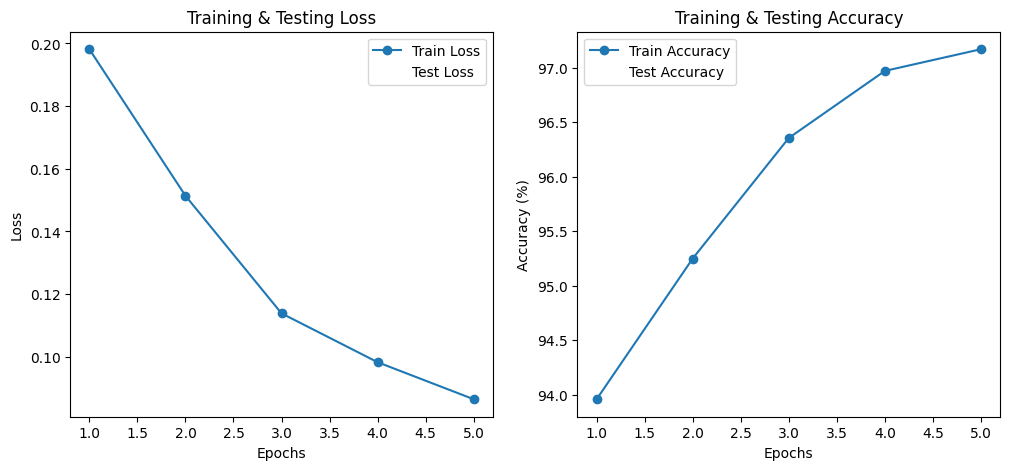

In [ ]:
# ✅ Plot Training & Testing Accuracy/Loss
epochs_range = range(1, 6)

plt.figure(figsize=(12, 5))

# Training & Testing Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
plt.axhline(test_loss, color="r", linestyle="..", label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss")
plt.legend()

# Training & Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
plt.axhline(test_accuracy, color="r", linestyle="..", label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Testing Accuracy")
plt.legend()

plt.show()

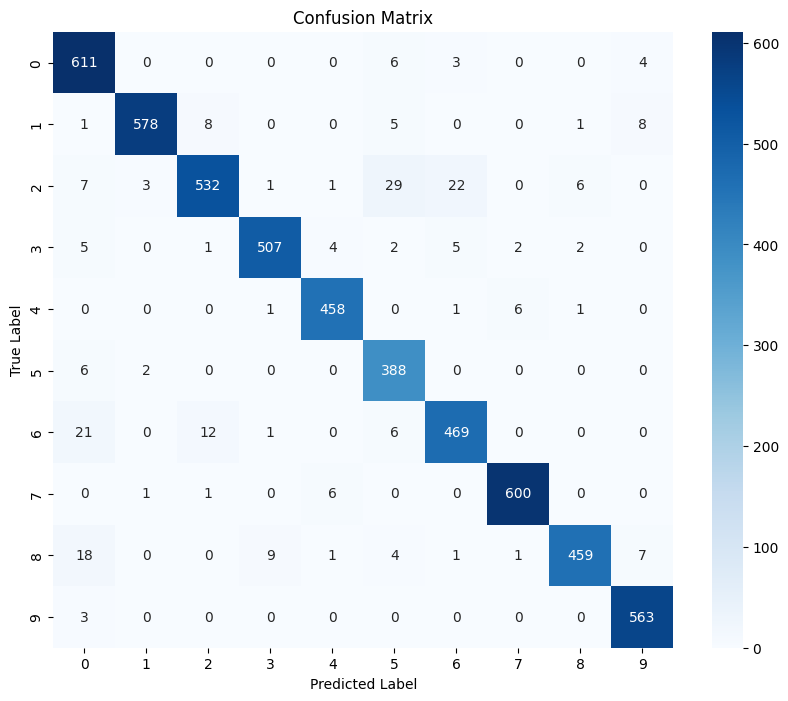

In [ ]:
# ✅ Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(info.features["label"].num_classes),
            yticklabels=range(info.features["label"].num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score
0              0.909226  0.979167  0.942901
1              0.989726  0.961730  0.975527
2              0.960289  0.885191  0.921212
3              0.976879  0.960227  0.968481
4              0.974468  0.980728  0.977588
5              0.881818  0.979798  0.928230
6              0.936128  0.921415  0.928713
7              0.985222  0.986842  0.986031
8              0.978678  0.918000  0.947368
9              0.967354  0.994700  0.980836
accuracy       0.956481  0.956481  0.956481
macro avg      0.955979  0.956780  0.955689
weighted avg   0.957731  0.956481  0.956452


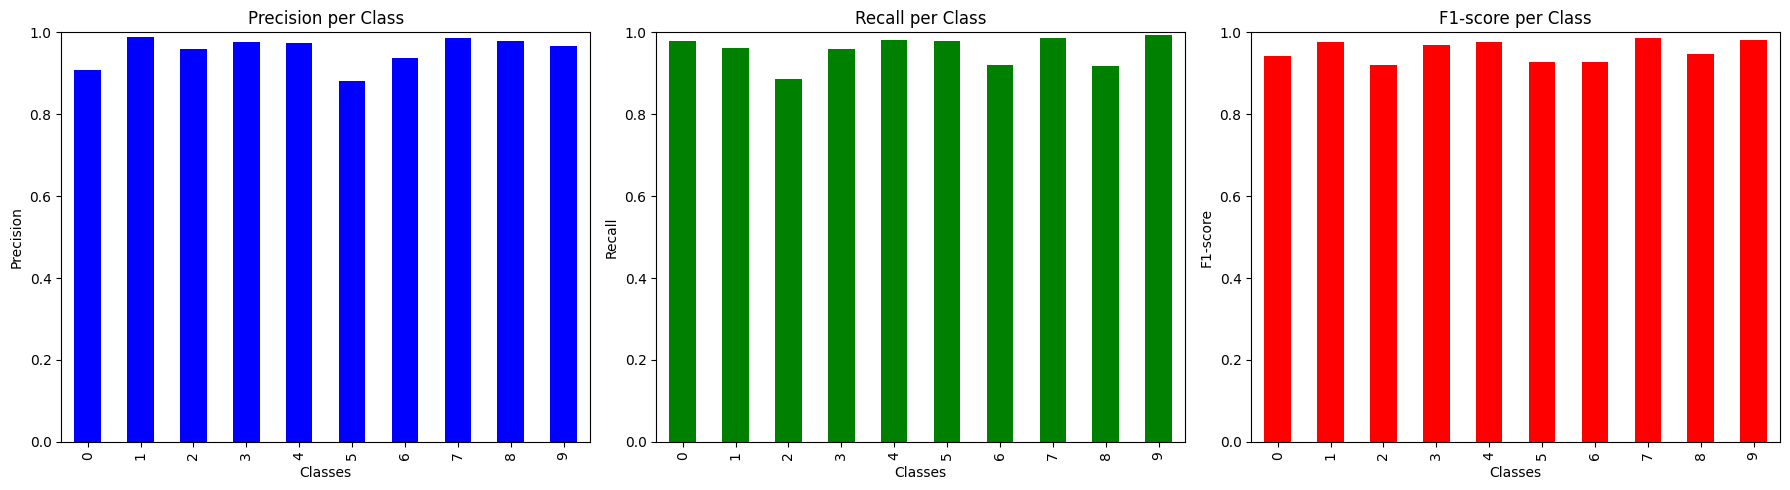

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have y_true and y_pred (true labels and model predictions)
report = classification_report(y_true, y_pred, output_dict=True)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Drop support column (not needed for plot)
df_report = df_report.drop(columns=["support"])

print(df_report)

# Plot precision, recall, and F1-score
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["precision", "recall", "f1-score"]
colors = ["blue", "green", "red"]

for i, metric in enumerate(metrics):
    df_report[metric][:-3].plot(kind="bar", ax=ax[i], color=colors[i])
    ax[i].set_title(f"{metric.capitalize()} per Class")
    ax[i].set_xlabel("Classes")
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()
